# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Условия задачи:**

•	Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

•	При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

•	Бюджет на разработку скважин в регионе — 10 млрд рублей.

•	При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

•	После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.



**Описание данных**


•	id — уникальный идентификатор скважины;

•	f0, f1, f2 — три признака точек;

•	product — объём запасов в скважине (тыс. баррелей).


## Загрузка и подготовка данных

In [14]:
#подключаем необходимые библиотеки для нашего проекта

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats as st
from numpy.random import RandomState
state = RandomState(12345)

In [15]:
data0 = pd.read_csv('/datasets/geo_data_0.csv')
data1 = pd.read_csv('/datasets/geo_data_1.csv')
data2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
#первые 5 строк каждого датасета
display(data0.head())
display(data1.head())
display(data2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [4]:
#изучим данные 
print('\n\nПервый датасет\n\n')
display(data0.info())
display(data0.describe())
print('\n\nВторой датасет\n\n')
display(data1.info())
display(data1.describe())
print('\n\nТретий датасет\n\n')
display(data2.info())
display(data2.describe())



Первый датасет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347




Второй датасет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408




Третий датасет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [5]:
#проверим дубликаты

print('Датасет 0, количество дубликатов: ',data0.duplicated().sum())
print('Датасет 1, количество дубликатов: ',data1.duplicated().sum())
print('Датасет 2, количество дубликатов: ',data2.duplicated().sum())

Датасет 0, количество дубликатов:  0
Датасет 1, количество дубликатов:  0
Датасет 2, количество дубликатов:  0


In [6]:
#проверим уникальные значения

data0.nunique()


id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [7]:
data1.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

In [8]:
data2.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

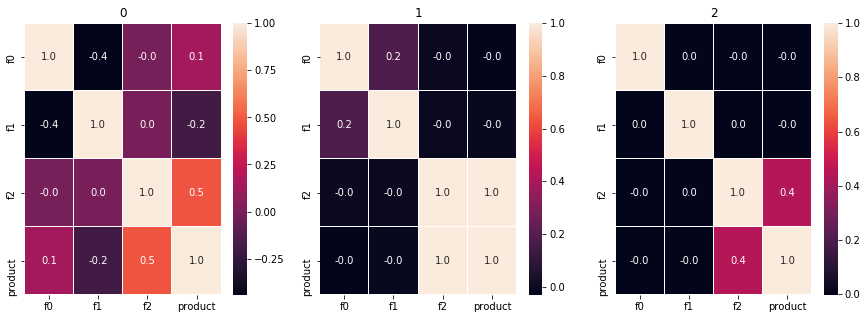

In [9]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i,j in zip([data0,data1,data2],range(3)):    
    sns.heatmap(i.corr(),annot=True, linewidths=.1, fmt= '.1f', ax=ax[j])
    ax[j].set_title(str(j))

In [10]:
#оценка корреляций признаков
display(data0.corr())
display(data1.corr())
display(data2.corr())

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


In [11]:
#посмотрим гистограмму распределения
#функция строит гистограмму и boxplot для выбранного параметра:

def show_hists(data, data_label, num_bins, rug=False, log_scale=False):
    
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(15, 4))
    axes[0].set_title(data_label + ". Плотность распределения", fontsize=14)
    axes[0].set_ylabel('Плотность', fontsize=14)
    sns.distplot(data, bins=num_bins, rug=rug, ax=axes[0], color="y")
    axes[1].set_title(data_label + ". Boxplot", fontsize=14)
    sns.boxplot(data=data, ax=axes[1], palette="Set2")
    plt.show()

In [12]:
def show_region(data, name):
    numerics = ['f0', 'f1', 'f2', 'product']
    for column in numerics:
        show_hists(data[column], name + ' ' + column, num_bins=15)

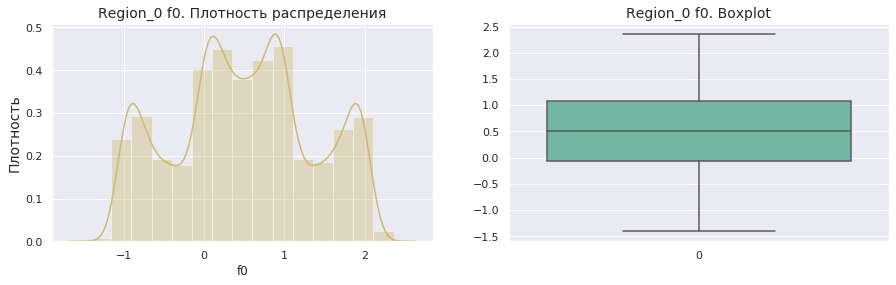

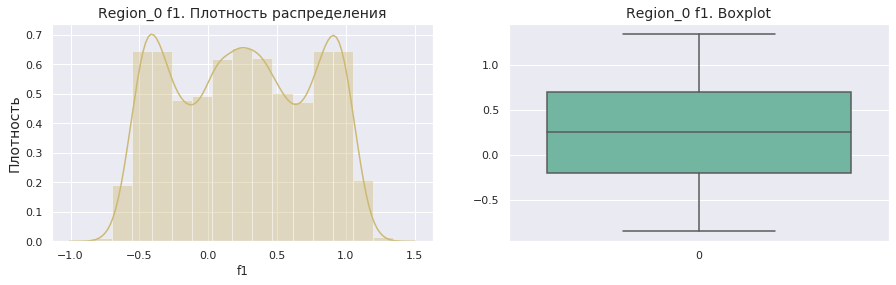

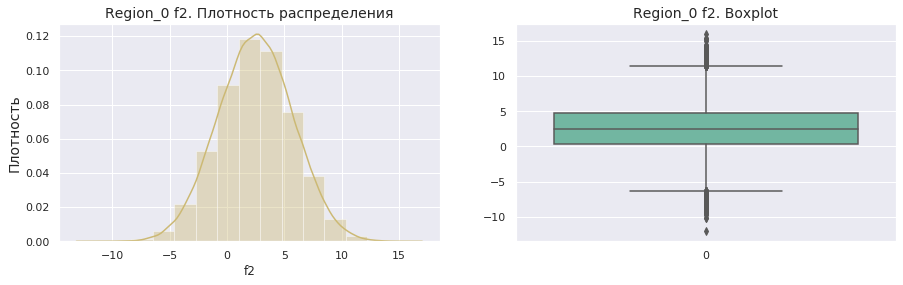

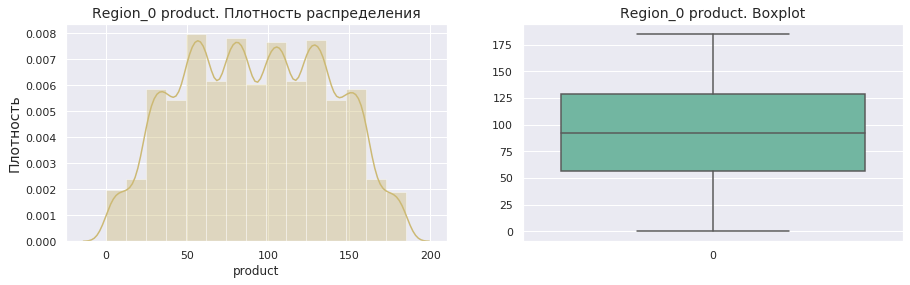

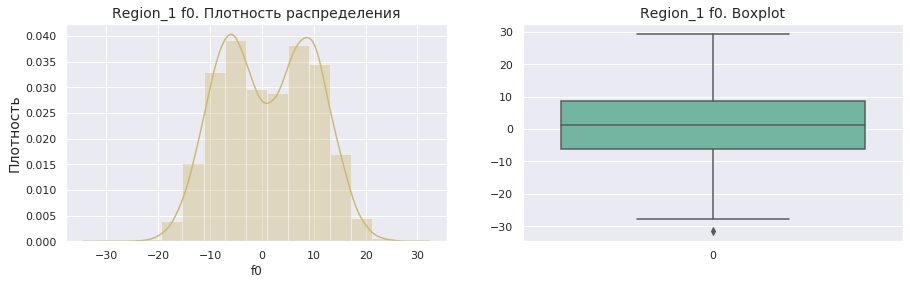

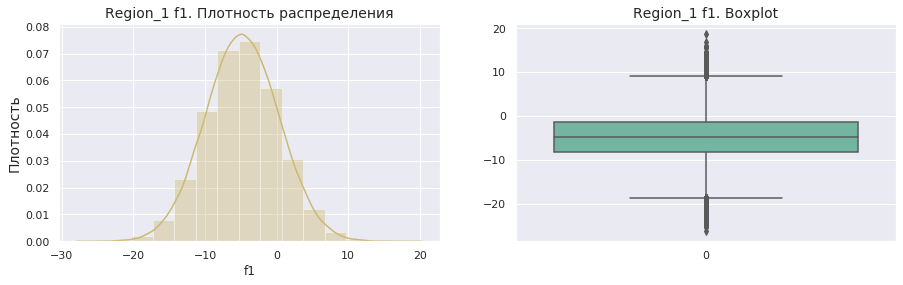

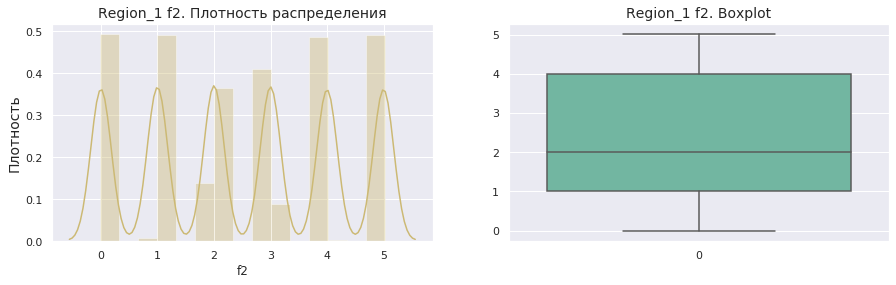

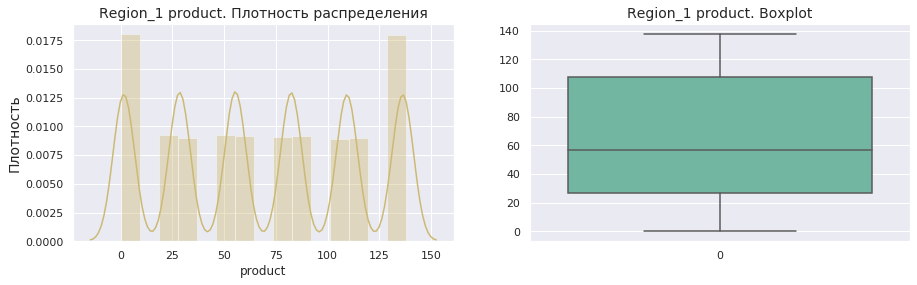

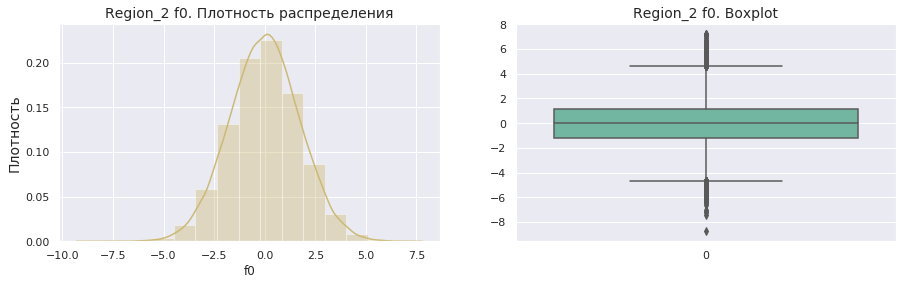

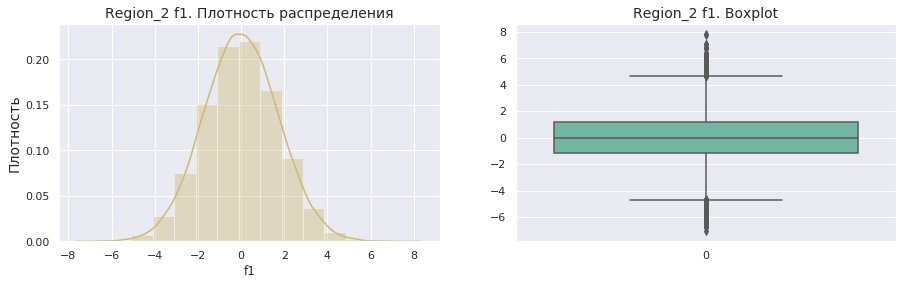

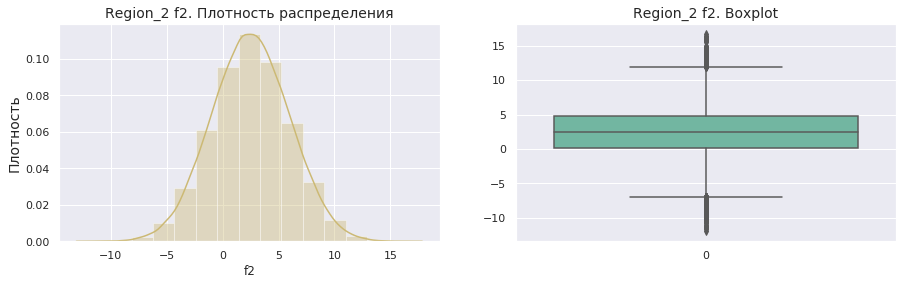

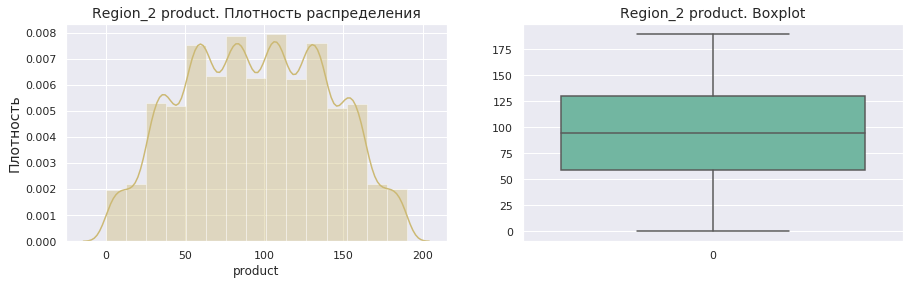

In [13]:
for data, name in [(data0, 'Region_0'), (data1, 'Region_1'), (data2, 'Region_2')]:
    show_region(data, name)

**Вывод**

В целом все датасеты хорошо подготовлены, типы данных корректные, дубликатов не имеется, пропущенных значений тоже.

Распределения некоторых признаков отличаются от нормального, присутствуют небольшие выбросы. 

Масштабы распределений признаков не сильно отличаются друг от друга, поэтому нет необходимости применять масштабирование.

Признак f2  сильно коррелирует с product.

У второго датасета уникальных значений в product всего 12. 

## Обучение и проверка модели

In [16]:
#создаем листы для хранения результатов прогнозирования и метрик
# проверим модели на всех трех датасетах и сохраним результаты метрик и прогнозирований в листы

rmse_list = []
predictions_list = []
score_list = []
target = []
predictions_df = pd.DataFrame()
target_df = pd.DataFrame()

for i,j in zip([data0,data1,data2],range(3)):
    X = i.drop(['product','id'], axis=1)
    y = i['product']
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, random_state=12345, test_size=0.25) 
    
    lr = LinearRegression(n_jobs = -1)
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_valid)
    rmse = np.sqrt(np.mean((y_valid-predictions)**2))
    rmse_list.append(rmse)
    predictions_list.append(predictions.mean())
    score_list.append(lr.score(X_train,y_train))
    target.append(i['product'].mean())
    target_df[j] = y_valid
    predictions_df[j] = predictions

In [17]:
#создадим таблицу, чтобы сравнить результаты
target_df = target_df.reset_index(drop=True)
scorelist = pd.DataFrame(
    data=[rmse_list, score_list, predictions_list, target], 
    index=['RMSE','SCORE','PREDICTED MEAN', 'TARGET MEAN'], 
    columns=['region 1','region 2','region 3'])
scorelist

,region 1,region 2,region 3
RMSE,37.579422,0.893099,40.029709
SCORE,0.274239,0.999625,0.196614
PREDICTED MEAN,92.592568,68.728547,94.965046
TARGET MEAN,92.500000,68.825000,95.000000


**Вывод**

Среднее спрогнозированное и среднее target практически одинаково.

Посмотрим на результаты у моделей:

Модели первого и третьего регионов показывают очень плохие результаты, их не рекомендуется использовать  для выбора скважины в регионе.

Модель второго региона показыла очень хорошие результаты, но у цели всего 12 значений из 100000, было легко спрогнозировать, поэтому вторая модель также неидеальна.



## Подготовка к расчёту прибыли

In [16]:
#Исходя из условий обозначим: 

budget = 10000000000   #бюджет на разработку скважин в регионе 
total_reconnaissance = 500 #при разведке исследуют 500 точек
profit_wells = 200  # 200 лучших скважин 
profit_from_one_barrel = 450   #прибыль с одного барреля сырья 
profit_from_one_product = 450000   #доход с каждой единицы продукта

In [17]:
#посчитаем цену за бурение одной скважины
well_drilling_price = budget / profit_wells
well_drilling_price

50000000.0

In [18]:
#достаточный объем сырья для безубыточной разработки новой скважины
min_product_mean  = well_drilling_price/profit_from_one_product
min_product_mean

111.11111111111111

**Вывод**



Минимальный объем сырья в каждой скважине должен составлять 111 тыс барелей. 
Cредние предсказания и средние target  регионов не проходят минимальный порог.

## Расчёт прибыли и рисков 

In [19]:
#функция для расчета прибыли по выбранным скважинам и предсказаниям. 

def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return (450000 * selected.sum() - (budget))

In [20]:
target_df.index.names == predictions_df.index.names

True

In [21]:
print('Прибыль 1 региона : {:.2f} млрд рублей'.format(revenue(target_df[0], predictions_df[0],200)/10**9))
print('Прибыль 2 региона : {:.2f} млрд рублей'.format(revenue(target_df[1], predictions_df[1],200)/10**9))
print('Прибыль 3 региона :{:.2f} млрд рублей'.format(revenue(target_df[2], predictions_df[2],200)/10**9))

Прибыль 1 региона : 3.32 млрд рублей
Прибыль 2 региона : 2.42 млрд рублей
Прибыль 3 региона :2.71 млрд рублей


In [22]:
#через bootstrap посчитаем среднюю прибыль , 95% доверительный интервал и риск убытков для первого региона
import scipy as sp
import scipy.stats

revenues = []

for i in range(1000):
    target_subsample = target_df[0].sample(n=500, replace=True, random_state=state)
    probs_subsample = predictions_df[0][target_subsample.index]
    revenues.append(revenue(target_subsample, probs_subsample, 200))

revenues = pd.Series(revenues)
lower = revenues.quantile(0.025)
mean = revenues.mean()
risks = (revenues < 0).mean()* 100
print("Средняя прибыль:", mean/10**9)
print("2.5% квантиль:", lower/10**9)
print("Риск: {}".format(risks))
final_revenues = []
confidence_interval = (revenues.quantile(0.025), revenues.quantile(0.975))
print('95% доверительный интервал: ', confidence_interval)
final_revenues.append(('region 1', mean/10**9, lower/10**9, confidence_interval, risks))

Средняя прибыль: 0.4259385269105923
2.5% квантиль: -0.10209009483793653
Риск: 6.0
95% доверительный интервал:  (-102090094.83793654, 947976353.358369)


In [23]:
#посчитаем среднюю прибыль , 95% доверительный интервал и риск убытков для второго региона
revenues = []

for i in range(1000):
    target_subsample = target_df[1].sample(n=500, replace=True, random_state=state)
    probs_subsample = predictions_df[1][target_subsample.index]
    revenues.append(revenue(target_subsample, probs_subsample, 200))

revenues = pd.Series(revenues)
lower = revenues.quantile(0.025)
mean = revenues.mean()
risks = (revenues < 0).mean()* 100
print("Средняя прибыль:", mean/10**9)
print("2.5%-квантиль:", lower/10**9)
print("Риск: {}".format(risks))
confidence_interval = (revenues.quantile(0.025), revenues.quantile(0.975))
print("Риск:", (revenues < 0).mean()* 100, '%')
print('95% доверительный интервал: ', confidence_interval)
final_revenues.append(('region 2', mean/10**9, lower/10**9, confidence_interval, risks))

Средняя прибыль: 0.5182594936973249
2.5%-квантиль: 0.1281232314330863
Риск: 0.3
Риск: 0.3 %
95% доверительный интервал:  (128123231.43308629, 953612982.0669085)


In [24]:
#посчитаем среднюю прибыль , 95% доверительный интервал и риск убытков для третьего региона
revenues = []
total_wells = 500
profit_wells = 200

for i in range(1000):
    target_subsample = target_df[2].sample(n=total_wells,replace=True, random_state=state)
    probs_subsample = predictions_df[2][target_subsample.index]
    revenues.append(revenue(target_subsample, probs_subsample, profit_wells))

revenues = pd.Series(revenues)
lower = revenues.quantile(0.025)
mean = revenues.mean()
risks = (revenues < 0).mean()* 100
#interval = interval = st.t.interval(0.95, len(revenues)-1, revenues.mean()/10**9, revenues.sem()/10**9)
print("Средняя прибыль:", mean/10**9)
print("2.5%-квантиль:", lower/10**9)
confidence_interval = (revenues.quantile(0.025), revenues.quantile(0.975))
print('95% доверительный интервал: ', confidence_interval)
print("Риск:", (revenues < 0).mean()* 100, '%')
final_revenues.append(('region 3', mean/10**9, lower/10**9, confidence_interval, risks))

Средняя прибыль: 0.42019400534405005
2.5%-квантиль: -0.11585260916001143
95% доверительный интервал:  (-115852609.16001143, 989629939.844574)
Риск: 6.2 %


In [25]:
report_df = pd.DataFrame(final_revenues, columns=['Region', 'Mean Revenue', 'Quantile 2.5%', 'Interval 95%', 'Risks %'])
cm = sns.light_palette("green", as_cmap=True)
s = report_df.style.background_gradient(cmap=cm)
s

,Region,Mean Revenue,Quantile 2.5%,Interval 95%,Risks %
0,region 1,0.425939,-0.10209,"(-102090094.83793654, 947976353.358369)",6
1,region 2,0.518259,0.128123,"(128123231.43308629, 953612982.0669085)",0.3
2,region 3,0.420194,-0.115853,"(-115852609.16001143, 989629939.844574)",6.2


**Вывод:**

Исходя из полученных данных, можно сказать, что наилучшие результаты показывает второй регион, так как добыча нефти в этом регионе связана с меньшим риском, но при этом обещает принести наибольшую выгоду.

**Общий вывод**

Мы исследовали три региона для прогнозирования объема сырья и прибыли. Данные были хорошо подготовлены, отсутствовали дубликаты, пустые значения. 

Второй отличался от других,  в столбце product были лишь 12 уникальных значений, именно это позволило модели хорошо делать прогнозы по второму региону, поэтому  использовать эту модель и сам регион довольно рискованно.

Далее мы провели расчет прибыли и пришли к выводу, что минимальный объем сырья должен составлять 111 тыс барелей. Наши средние показатели трех регионов не доходили до этого минимального порога.

Исходя из всех полученных данных, можно сделать вывод, что второй регион имеет наибольшие шансы на получение прибыли, но учитывая исходные данные, использовать его тоже довольно рискованно.